# Meta-Feature Engineering

In this notebook, meta-features are created from historical data of test users. These will be then used by classifier to identify optimal base-level algorithm for each user.

This notebook is structured as follows:

    1 Domain independent features
        1.1 Matrix based features
        1.2 Graph based features
        1.3 Timestamp based features
    2 Domain specific features
        2.1 Item attributes extraction from database and anonymization
        2.2 Feature creation

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from ast import literal_eval
from multiprocessing import Pool
from collections import Counter
import time
from datetime import timedelta
import datetime
import psycopg2 as pg
import pandas.io.sql as psql
%matplotlib inline

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [12, 4]

DATA_PATH = 'data/fstore/'
METRIC = 'NDCG@100'

In [3]:
rs_train = pd.read_csv(DATA_PATH+'raw/history.csv')

## 1 Domain independent features

### 1.1 Matrix based features

In [4]:
rs_perf = pd.read_csv(DATA_PATH+'rs_performance.csv')

In [5]:
rs_perf[METRIC] = rs_perf[METRIC].apply(lambda x: literal_eval(x))

In [6]:
data = rs_perf[rs_perf[METRIC].apply(lambda x: x[0][0] > 0)][['user_id', METRIC]]
data['class'] = data[METRIC].apply(lambda x: x[0][1])
data.head()

,user_id,NDCG@100,class
2,2,"[[0.056316753775798256, popular], [0.054120274...",popular
3,3,"[[0.06435448568843775, itemknn], [0.0630680314...",itemknn
4,4,"[[0.412416442009166, bpr], [0.2353703166846384...",bpr
5,7,"[[0.21303136023417987, als], [0.19047539731574...",als
7,9,"[[0.08314885321150761, als], [0.06674284474627...",als


In [7]:
data.shape

(49154, 3)

In [14]:
rs_train_iids_per_uid = rs_train.groupby('user_id')['item_id'].apply(list).reset_index()

In [9]:
data = data.join(rs_train_iids_per_uid, how='inner', on='user_id', rsuffix='_')

In [10]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id
2,2,"[[0.056316753775798256, popular], [0.054120274...",popular,2,"[13048, 21368, 29352, 33296, 33304, 33972]"
3,3,"[[0.06435448568843775, itemknn], [0.0630680314...",itemknn,3,"[3459, 5000, 8440, 14042, 19648, 21308, 23532,..."
4,4,"[[0.412416442009166, bpr], [0.2353703166846384...",bpr,4,"[14895, 19629, 24096]"
5,7,"[[0.21303136023417987, als], [0.19047539731574...",als,7,[26187]
7,9,"[[0.08314885321150761, als], [0.06674284474627...",als,9,"[9491, 12466, 14655, 16324, 19636, 19658, 2147..."


In [11]:
data['unique_items'] = data.item_id.apply(len)

In [12]:
%%time
num_cores = 12 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def compute_intersect_cardinality(df):
    df['itemsets_intersect_cardinality'] = df.apply(lambda x: list(filter((0).__ne__, 
        [len(set(x.item_id).intersection(set(ilist))) for u, ilist in enumerate(rs_train_iids_per_uid.item_id.values.tolist())
        if u != x.user_id])), axis=1)
    return df
    

data = parallelize_dataframe(data, compute_intersect_cardinality)

CPU times: user 2min 21s, sys: 56.5 s, total: 3min 17s
Wall time: 1d 5h 56min 25s


In [13]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

In [4]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [5]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality
0,2,"[[0.056316753775798256, popular], [0.054120274...",popular,2,"[13048, 21368, 29352, 33296, 33304, 33972]",6,"[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,3,"[[0.06435448568843775, itemknn], [0.0630680314...",itemknn,3,"[3459, 5000, 8440, 14042, 19648, 21308, 23532,...",38,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ..."
2,4,"[[0.412416442009166, bpr], [0.2353703166846384...",bpr,4,"[14895, 19629, 24096]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ..."
3,7,"[[0.21303136023417987, als], [0.19047539731574...",als,7,[26187],1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,9,"[[0.08314885321150761, als], [0.06674284474627...",als,9,"[9491, 12466, 14655, 16324, 19636, 19658, 2147...",28,"[1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ..."


In [6]:
data.shape

(49154, 7)

Text(0.5,1,'Per user max cardinality of itemset itersection')

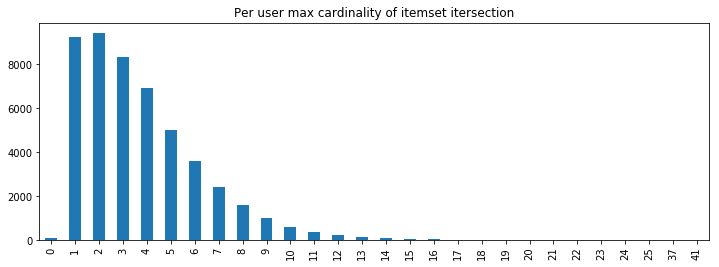

In [7]:
data.itemsets_intersect_cardinality.apply(lambda x: max(x) if len(x) > 0 else 0).value_counts().sort_index().plot(kind='bar')
plt.title('Per user max cardinality of itemset itersection')

In [8]:
%%time
num_cores = 12 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def create_meta_features(df):
    for i in range(1, 11):
        df['users_sharing_'+str(i)] = df.itemsets_intersect_cardinality.apply(lambda x: x.count(i))
        df['users_sharing_'+str(i)+'+'] = df.itemsets_intersect_cardinality.apply(lambda x: [c>=i for c in x].count(True))
        df['users_sharing_'+str(10*i)+'%+'] = df.apply(lambda x: 
                [c/x.unique_items >= i/10 for c in x.itemsets_intersect_cardinality].count(True), axis=1)

    # how many other users have seen user's items
    df['item_appearance'] = df.item_id.apply(lambda x: [item_appearance[item_id] for item_id in x])
    df['item_appearance_q1'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.25))
    df['item_appearance_q2'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.5))
    df['item_appearance_q3'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.75))
    df['item_appearance_mean'] = df.item_appearance.apply(lambda x: np.mean(x))
    df['item_appearance_min'] = df.item_appearance.apply(lambda x: np.min(x))
    df['item_appearance_max'] = df.item_appearance.apply(lambda x: np.max(x))
    return df
    

item_appearance = rs_train.groupby('item_id')['user_id'].count()
data = parallelize_dataframe(data, create_meta_features)

CPU times: user 32 s, sys: 6.38 s, total: 38.4 s
Wall time: 1h 57min 35s


In [9]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

### 1.2 Graph based features

In [10]:
rs_train_uids_per_iid = rs_train.groupby('item_id')['user_id'].apply(list).reset_index()

In [15]:
%%time
num_cores = 12 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def search_iids(row, depth):
    if depth>1:
        iids = []
        for uid in row['g_depth_'+str(depth-1)+'_ids']:
            iids += rs_train_iids_per_uid.loc[uid].item_id
        iids = [iid for iid in iids if iid not in row['g_depth_'+str(depth-2)+'_ids']] # remove edges to ids in depth-2
        edges = len(iids)
        iids = list(set(iids)) # remove duplicates
        # avoid memory error
        if depth == 3:
            return pd.Series((len(iids), edges))
        return pd.Series((iids, edges))
    else:
        return pd.Series((row.item_id, len(row.item_id)))
    
def search_uids(row, depth):
    if depth>2:
        uids = []
        for iid in row['g_depth_'+str(depth-1)+'_ids']:
            uids += rs_train_uids_per_iid.loc[iid].user_id
        uids = [uid for uid in uids if uid not in row['g_depth_'+str(depth-2)+'_ids']] # remove edges to ids in depth-2
        edges = len(uids)
        uids = list(set(uids)) # remove duplicates
        return pd.Series((uids, edges))
    else:
        uids = []
        for iid in row['g_depth_'+str(depth-1)+'_ids']:
            uids += rs_train_uids_per_iid.loc[iid].user_id
        uids = [uid for uid in uids if uid is not row.user_id] # remove edges to ids in depth-2
        edges = len(uids)
        uids = list(set(uids)) # remove duplicates
        return pd.Series((uids, edges))

def search_graph(df):
    for depth in range(1, 4):
        start = time.time()
        print(depth, 'start')
        if depth%2 == 1: # searching iids
            df[['g_depth_'+str(depth)+'_ids', 'g_depth_'+str(depth)+'_edges_'+str(depth-1)]] \
                = df.apply(search_iids, args=(depth,), axis=1)
        else: # searching uids
            df[['g_depth_'+str(depth)+'_ids', 'g_depth_'+str(depth)+'_edges_'+str(depth-1)]] \
                = df.apply(search_uids, args=(depth,), axis=1)
        print(depth, 'took', str(timedelta(seconds=time.time() - start)))
    return df

data = parallelize_dataframe(data, search_graph)

1 start
1 start
1 start
1 start
1 took 0:00:04.345127
2 start
1 start
1 took 0:00:04.901832
2 start
1 start
1 took 0:00:04.680275
2 start
1 took 0:00:05.097198
2 start
1 start
1 took 0:00:04.994502
2 start
1 start
1 took 0:00:05.381447
2 start
1 start
1 start
1 start
1 took 0:00:06.708437
2 start
1 took 0:00:05.101569
2 start
1 start
1 took 0:00:05.995136
2 start
1 took 0:00:05.665759
2 start
1 took 0:00:05.058947
2 start
1 took 0:00:05.257819
2 start
2 took 0:12:00.403639
3 start
2 took 0:12:16.402256
3 start
2 took 0:12:14.509346
3 start
2 took 0:12:36.840924
3 start
2 took 0:12:54.026305
3 start
2 took 0:13:13.724901
3 start
2 took 0:13:17.666017
3 start
2 took 0:13:18.236677
3 start
2 took 0:13:23.851654
3 start
2 took 0:13:34.553288
3 start
2 took 0:14:16.440732
3 start
2 took 0:14:29.596560
3 start
3 took 7:11:03.616080
3 took 7:15:33.989851
3 took 7:17:47.723954
3 took 7:19:40.925001
3 took 7:18:27.097022
3 took 7:19:18.732049
3 took 7:22:41.281541
3 took 7:21:29.432011
3 took 7

In [16]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

In [17]:
data.g_depth_1_ids.apply(len).describe()

count    49154.000000
mean        13.234996
std         15.417042
min          1.000000
25%          2.000000
50%          7.000000
75%         18.000000
max         97.000000
Name: g_depth_1_ids, dtype: float64

In [18]:
data.g_depth_2_ids.apply(len).describe()

count    49154.000000
mean      3224.196993
std       3565.438858
min          1.000000
25%        535.000000
50%       1959.000000
75%       4715.000000
max      26955.000000
Name: g_depth_2_ids, dtype: float64

In [19]:
data.g_depth_3_ids.describe()

count    49154.000000
mean     11772.815783
std       6553.196379
min          0.000000
25%       6403.250000
50%      11901.000000
75%      17093.750000
max      27009.000000
Name: g_depth_3_ids, dtype: float64

In [20]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality,users_sharing_1,users_sharing_1+,users_sharing_10%+,...,item_appearance_q3,item_appearance_mean,item_appearance_min,item_appearance_max,g_depth_1_ids,g_depth_1_edges_0,g_depth_2_ids,g_depth_2_edges_1,g_depth_3_ids,g_depth_3_edges_2
0,2,"[[0.056316753775798256, popular], [0.054120274...",popular,2,"[13048, 21368, 29352, 33296, 33304, 33972]",6,"[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",994,1071,1071,...,267.75,192.833333,32,515,"[13048, 21368, 29352, 33296, 33304, 33972]",6,"[24576, 38916, 61446, 2055, 55302, 88073, 7169...",1151,10156,31712
1,3,"[[0.06435448568843775, itemknn], [0.0630680314...",itemknn,3,"[3459, 5000, 8440, 14042, 19648, 21308, 23532,...",38,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",11984,16060,393,...,695.75,578.473684,65,2394,"[3459, 5000, 8440, 14042, 19648, 21308, 23532,...",38,"[32768, 98305, 32770, 98306, 5, 98311, 32777, ...",21944,24212,353125
2,4,"[[0.412416442009166, bpr], [0.2353703166846384...",bpr,4,"[14895, 19629, 24096]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...",550,566,566,...,272.50,195.000000,40,288,"[14895, 19629, 24096]",3,"[4096, 79873, 69636, 8196, 16390, 10247, 47108...",582,6171,16923
3,7,"[[0.21303136023417987, als], [0.19047539731574...",als,7,[26187],1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1146,1146,1146,...,1147.00,1147.000000,1147,1147,[26187],1,"[24576, 55297, 26625, 34819, 2052, 6151, 81933...",1146,9103,26543
4,9,"[[0.08314885321150761, als], [0.06674284474627...",als,9,"[9491, 12466, 14655, 16324, 19636, 19658, 2147...",28,"[1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",6505,7422,139,...,319.50,304.714286,9,1499,"[9491, 12466, 14655, 16324, 19636, 19658, 2147...",28,"[98316, 98326, 65558, 32799, 32806, 65577, 655...",8504,19403,190331


In [22]:
%%time

def count_edges(row, depth, init_depth):
    edges = 0
    for i in range(init_depth, depth):
        edges += row['g_depth_'+str(i+1)+'_edges_'+str(i)]
    return edges

def get_possible_edges(row, depth, init_depth):
    items = 0
    users = 0
    for i in range(init_depth, depth+1):
        if i%2 == 1:
            users += row['g_depth_'+str(i)+'_vertices']
        else:
            items += row['g_depth_'+str(i)+'_vertices']
    return items*users

data['g_depth_0_vertices'] = 1
for depth in range(1, 4):
    if depth < 3:
        data['g_depth_'+str(depth)+'_vertices'] = data['g_depth_'+str(depth)+'_ids'].apply(len)
    else:
        data['g_depth_'+str(depth)+'_vertices'] = data['g_depth_'+str(depth)+'_ids']
    for init_depth in range(0, depth-1):
        data['g_depth_'+str(depth)+'_edges_'+str(init_depth)] = data.apply(count_edges, args=(depth, init_depth), axis=1)
    for init_depth in range(0, depth):    
        data['g_depth_'+str(depth)+'_possible_edges_'+str(init_depth)] = data.apply(get_possible_edges, args=(depth, init_depth), axis=1)
        data['g_depth_'+str(depth)+'_density_'+str(init_depth)] = data['g_depth_'+str(depth)+'_edges_'+str(init_depth)] \
                                                                / data['g_depth_'+str(depth)+'_possible_edges_'+str(init_depth)]
        # solve NaNs
        data['g_depth_'+str(depth)+'_density_'+str(init_depth)] = data['g_depth_'+str(depth)+'_density_'+str(init_depth)] \
                                                                .apply(lambda x: x if x > 0 else 0)

CPU times: user 39.8 s, sys: 18.8 s, total: 58.6 s
Wall time: 32 s


In [23]:
data.shape

(49154, 69)

In [24]:
data.loc[1]

user_id                                                                           3
NDCG@100                          [[0.06435448568843775, itemknn], [0.0630680314...
class                                                                       itemknn
user_id_                                                                          3
item_id                           [3459, 5000, 8440, 14042, 19648, 21308, 23532,...
unique_items                                                                     38
itemsets_intersect_cardinality    [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...
users_sharing_1                                                               11984
users_sharing_1+                                                              16060
users_sharing_10%+                                                              393
users_sharing_2                                                                2839
users_sharing_2+                                                            

In [25]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

### 1.3 Timestamp based features

In [36]:
rs_train['seconds_diff'] = rs_train.ts_first.apply(lambda x: (datetime.datetime.strptime('2018-06-20 00:00:00', '%Y-%m-%d %H:%M:%S') \
                                                             - datetime.datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')).total_seconds())

In [37]:
diff_min = rs_train.groupby('user_id')['seconds_diff'].min()
diff_max = rs_train.groupby('user_id')['seconds_diff'].max()
diff_mean = rs_train.groupby('user_id')['seconds_diff'].mean()
diff_q1 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.25))
diff_q2 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.5))
diff_q3 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.75))

In [38]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
#data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
#data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
#data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [39]:
data['seconds_diff_min'] = data.user_id.apply(lambda uid: diff_min[uid])
data['seconds_diff_max'] = data.user_id.apply(lambda uid: diff_max[uid])
data['seconds_diff_mean'] = data.user_id.apply(lambda uid: diff_mean[uid])
data['seconds_diff_q1'] = data.user_id.apply(lambda uid: diff_q1[uid])
data['seconds_diff_q2'] = data.user_id.apply(lambda uid: diff_q2[uid])
data['seconds_diff_q3'] = data.user_id.apply(lambda uid: diff_q3[uid])

In [40]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

## 2 Domain specific features

### 2.1 Item attributes extraction from database and anonymization

In [58]:
conn = pg.connect(...secret...)

In [59]:
%%time
items_info = psql.read_sql("""
SELECT
    id AS product_id,
    price,
    brand_price_level,
    brand,
    SPLIT_PART(category, '>', 1) AS category1,
    SPLIT_PART(category, '>', 2) AS category2,
    SPLIT_PART(category, '>', 3) AS category3,
    SPLIT_PART(category, '>', 4) AS category4,
    category AS category_full,
    color,
    CASE 
        WHEN gender IS NULL THEN '-'
        ELSE gender
    END AS gender
FROM
    fstore.products
""", conn)
conn.close()

CPU times: user 1.31 s, sys: 144 ms, total: 1.45 s
Wall time: 1.93 s


In [62]:
def get_last_category(row):
    if row.category4 != '':
        return row.category4
    if row.category3 != '':
        return row.category3
    if row.category2 != '':
        return row.category2
    if row.category1 != '':
        return row.category1
    
items_info['category_last'] = items_info.apply(get_last_category, axis=1)

In [63]:
df_categories = pd.DataFrame()
df_categories['category'] = pd.concat([items_info.category1,
                                       items_info.category2,
                                       items_info.category3,
                                       items_info.category4])
df_categories['category_id'] = df_categories.category.astype("category").cat.codes
df_categories = df_categories.groupby('category')['category_id'].min()

In [64]:
items_info['category1'] = items_info['category1'].apply(lambda category: df_categories[category])
items_info['category2'] = items_info['category2'].apply(lambda category: df_categories[category])
items_info['category3'] = items_info['category3'].apply(lambda category: df_categories[category])
items_info['category4'] = items_info['category4'].apply(lambda category: df_categories[category])
items_info['category_last'] = items_info['category_last'].apply(lambda category: df_categories[category])

items_info['brand'] = items_info['brand'].astype("category").cat.codes
items_info['brand_price_level'] = items_info['brand_price_level'].astype("category").cat.codes
items_info['gender'] = items_info['gender'].astype("category").cat.codes
items_info['color'] = items_info['color'].astype("category").cat.codes
items_info['category_full'] = items_info['category_full'].astype("category").cat.codes

max_price = items_info.price.max()
items_info['price'] = items_info['price'] / max_price

In [65]:
raw_data = pd.read_csv(DATA_PATH+'/raw/data.csv')
raw_data = raw_data.groupby('product_id')['item_id'].min().reset_index()

items_info = pd.merge(raw_data, items_info, on='product_id', how='inner').drop('product_id', axis=1)

In [71]:
items_info.set_index('item_id', inplace=True)

### 2.2 Feature creation

In [49]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
#data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
#data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [98]:
%%time
num_cores = 12 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def get_stats(row, attribute):
    values = []
    for iid in row.item_id:
        if iid in items_info.index:
            values.append(items_info.loc[iid][attribute])
    if len(values) > 0:
        return pd.Series((
            min(values),
            max(values),
            np.mean(values),
            np.quantile(values, q=.25),
            np.quantile(values, q=.5),
            np.quantile(values, q=.75)
        ))
    else:
        return pd.Series((np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))

def get_nUnique_topCount_topCountNormalized(row, attribute):
    counter = Counter()
    for iid in row.item_id:
        if iid in items_info.index:
            counter[items_info.loc[iid][attribute]] += 1
    if len(counter) > 0:
        return pd.Series((len(counter), counter.most_common(1)[0][1], counter.most_common(1)[0][1] / sum(counter.values())))
    else:
        return pd.Series((1, 1, 1 / 1))

def get_domain_based_features(df):
    df[['ds_price_min',
        'ds_price_max',
        'ds_price_mean',
        'ds_price_q1',
        'ds_price_q2',
        'ds_price_q3']] = df.apply(get_stats, args=('price',), axis=1)
    for attr in ['brand', 'brand_price_level', 'category_full', 'category1', 'category2', 'category3', 'category4', 'category_last', 'gender', 'color']:
        df[['ds_' + attr + '_nunique',
              'ds_' + attr + '_top_count',
              'ds_' + attr + '_top_count_normalized']] = df.apply(get_nUnique_topCount_topCountNormalized, args=(attr,), axis=1)
    return df

data = parallelize_dataframe(data, get_domain_based_features)

CPU times: user 4.6 s, sys: 18.6 s, total: 23.2 s
Wall time: 7min 29s


In [99]:
data.shape

(49154, 111)

In [100]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality,users_sharing_1,users_sharing_1+,users_sharing_10%+,...,ds_category4_top_count_normalized,ds_category_last_nunique,ds_category_last_top_count,ds_category_last_top_count_normalized,ds_gender_nunique,ds_gender_top_count,ds_gender_top_count_normalized,ds_color_nunique,ds_color_top_count,ds_color_top_count_normalized
0,2,"[[0.056316753775798256, 'popular'], [0.0541202...",popular,2,"[13048, 21368, 29352, 33296, 33304, 33972]",6,"[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",994,1071,1071,...,1.000000,2.0,5.0,0.833333,1.0,6.0,1.0,4.0,3.0,0.500000
1,3,"[[0.06435448568843775, 'itemknn'], [0.06306803...",itemknn,3,"[3459, 5000, 8440, 14042, 19648, 21308, 23532,...",38,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",11984,16060,393,...,0.368421,4.0,14.0,0.368421,1.0,38.0,1.0,11.0,12.0,0.315789
2,4,"[[0.412416442009166, 'bpr'], [0.23537031668463...",bpr,4,"[14895, 19629, 24096]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...",550,566,566,...,1.000000,1.0,3.0,1.000000,1.0,3.0,1.0,3.0,1.0,0.333333
3,7,"[[0.21303136023417987, 'als'], [0.190475397315...",als,7,[26187],1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1146,1146,1146,...,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000
4,9,"[[0.08314885321150761, 'als'], [0.066742844746...",als,9,"[9491, 12466, 14655, 16324, 19636, 19658, 2147...",28,"[1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",6505,7422,139,...,0.464286,6.0,13.0,0.464286,1.0,28.0,1.0,13.0,5.0,0.178571


In [110]:
len(data[data.ds_price_min.isna()])

63

In [112]:
price_means = {
    'ds_price_min': data['ds_price_min'].mean(),
    'ds_price_max': data['ds_price_max'].mean(),
    'ds_price_mean': data['ds_price_mean'].mean(),
    'ds_price_q1': data['ds_price_q1'].mean(),
    'ds_price_q2': data['ds_price_q2'].mean(),
    'ds_price_q3': data['ds_price_q3'].mean()
}

In [117]:
data.fillna(price_means, inplace=True)

In [121]:
data.drop(columns=[
    # lists:
    METRIC, 'user_id_', 'item_id', 'itemsets_intersect_cardinality', 'item_appearance', 'g_depth_1_ids', 'g_depth_2_ids', 'g_depth_3_ids',
    # ones
    'g_depth_0_vertices', 'g_depth_1_density_0',
    # = unique_items
    'g_depth_1_edges_0', 'g_depth_1_vertices', 'g_depth_1_possible_edges_0'
], inplace=True)

In [122]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)